## GeneChip® Expression Analysis

Affymetrix is dedicated to helping you design and analyze GeneChip® expression profiling experiments that generate high-quality, statistically sound, and biologically interesting results.

There is a diverse range of experimental objectives and uses for GeneChip microarray data, which makes the areas of experimental design and data analysis quite broad in scope. As such, there are many ways to design expression profiling experiments, as well as many ways to analyze and mine data.

Single Array Analysis

Single array analysis can be used to build databases of gene expression profiles, facilitate sample classification and transcript clustering, and monitor gross expression characteristics.
In addition, the analyses provide the initial data required to perform comparisons between experiment and baseline arrays.

This analysis generates a Detection p-value which is evaluated against user-definable cut-offs to determine the Detection call. This call indicates whether a transcript is reliably detected(Present) or not detected (Absent). 

Detection Call

The user-modifiable Detection p-value cut-offs, Alpha 1 (α1) and Alpha 2 (α 2), provide boundaries for defining Present, Marginal, or Absent calls. At the default settings, determined for probe sets with 16–20 probe pairs (defaults α 1 = 0.04 and α 2 = 0.06), any p-value that falls below α 1 is assigned a Present call, and above α 2 is assigned an Absent call. Marginal calls are given to probe sets which have p-values between α 1 and α 2. The p-value cut-offs can be adjusted to increase or decrease sensitivity and specificity.

Signal Algorithm

Signal is a quantitative metric calculated for each probe set, which represents the **relative level of expression** of a transcript. Signal is calculated using the One-Step Tukey’s Biweight Estimate which yields a robust weighted mean that is relatively insensitive to outliers, even when extreme.

Similar to the Detection algorithm, each probe pair in a probe set is considered as having a potential vote in determining the Signal value. The vote, in this case, is defined as an estimate of the real signal due to hybridization of the target. The mismatch intensity is used to estimate stray signal. The real signal is estimated by taking the log of the Perfect Match
intensity after subtracting the stray signal estimate. The probe pair vote is weighted more strongly if this probe pair Signal value is closer to the median value for a probe set. Once the weight of each probe pair is determined, the mean of the weighted intensity values for a probe set is identified. This mean value is corrected back to linear scale and is output as Signal.

When the Mismatch intensity is lower than the Perfect Match intensity, then the Mismatch is informative and provides an estimate of the stray signal. Rules are employed in the Signal algorithm to ensure that negative Signal values are not calculated. Negative values do not make physiological sense and make further data processing, such as log transformations,
difficult. Mismatch values can be higher than Perfect Match values for a number of reasons, such as cross hybridization. If the Mismatch is higher than the Perfect Match, the Mismatch provides no additional information about the estimate of stray signal. Therefore, an imputed value called Idealized Mismatch (IM) is used instead of the uninformative Mismatch

The following rules are applied:

Rule 1: If the Mismatch value is less than the Perfect Match value, then the Mismatch value is considered informative and the intensity value is used directly as an estimate of stray signal.

Rule 2: If the Mismatch probe cells are generally informative across the probe set except for a few Mismatches, an adjusted Mismatch value is used for uninformative Mismatches based on the biweight mean of the Perfect Match and Mismatch ratio.

Rule 3: If the Mismatch probe cells are generally uninformative, the uninformative Mismatches are replaced with a value that is slightly smaller than the Perfect Match. These probe sets are generally called Absent by the Detection algorithm.

** Let's start the analysis**

**Required Imports**

In [15]:
import itertools
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import scipy
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Grid Search for tuning parameters
from sklearn.model_selection import GridSearchCV

# RandomizedSearch for tuning (possibly faster than GridSearch)
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

**Loading Datasets**

In [2]:
testfile = 'data_set_ALL_AML_independent.csv'
trainfile = 'data_set_ALL_AML_train.csv'
labelfile = 'actual.csv'

train = pd.read_csv(trainfile)
test = pd.read_csv(testfile)
patient_cancer = pd.read_csv(labelfile)
train

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A
5,AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-5_at,-558,A,-400,A,-650,A,-585,A,...,-155,A,-344,A,-508,A,-423,A,-566,A
6,AFFX-BioDn-3_at (endogenous control),AFFX-BioDn-3_at,199,A,-330,A,33,A,158,A,...,29,A,324,A,-349,A,-31,A,-141,A
7,AFFX-CreX-5_at (endogenous control),AFFX-CreX-5_at,-176,A,-168,A,-367,A,-253,A,...,-105,A,-237,A,-194,A,-223,A,-315,A
8,AFFX-CreX-3_at (endogenous control),AFFX-CreX-3_at,252,A,101,A,206,A,49,A,...,42,A,105,A,34,A,-82,A,206,A
9,AFFX-BioB-5_st (endogenous control),AFFX-BioB-5_st,206,A,74,A,-215,A,31,A,...,524,A,167,A,-56,A,176,A,321,A


This analisis is going to focus on recognice acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL) by gen expresion whitout influence of the detection call results since this datasets have very poor quality of gen detection signal.

**Data Cleaning**

In [3]:
# Remove "call" columns from training a test dataframes
train_keepers = [col for col in train.columns if "call" not in col]
test_keepers = [col for col in test.columns if "call" not in col]

train = train[train_keepers]
test = test[test_keepers]

# Transpose the columns and rows so that genes become features and rows become observations
train = train.T
test = test.T

# Clean up the column names for training data
train.columns = train.iloc[1]
train = train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for testing data
test.columns = test.iloc[1]
test = test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [4]:
# Reset the index. The indexes of two dataframes need to be the same before you combine them
train = train.reset_index(drop=True)

# Subset the first 38 patient's cancer types
pc_train = patient_cancer[patient_cancer.patient <= 38].reset_index(drop=True)

# Combine dataframes for first 38 patients: Patient number + cancer type + gene expression values
train = pd.concat([pc_train,train], axis=1)


# Handle the test data for patients 38 through 72
# Clean up the index
test = test.reset_index(drop=True)

# Subset the last patient's cancer types to test
pc_test = patient_cancer[patient_cancer.patient > 38].reset_index(drop=True)

# Combine dataframes for last patients: Patient number + cancer type + gene expression values
test = pd.concat([pc_test,test], axis=1)

train

,patient,cancer,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,1,ALL,-214,-153,-58,88,-295,-558,199,-176,...,185,511,-125,389,-37,793,329,36,191,-37
1,2,ALL,-139,-73,-1,283,-264,-400,-330,-168,...,169,837,-36,442,-17,782,295,11,76,-14
2,3,ALL,-76,-49,-307,309,-376,-650,33,-367,...,315,1199,33,168,52,1138,777,41,228,-41
3,4,ALL,-135,-114,265,12,-419,-585,158,-253,...,240,835,218,174,-110,627,170,-50,126,-91
4,5,ALL,-106,-125,-76,168,-230,-284,4,-122,...,156,649,57,504,-26,250,314,14,56,-25
5,6,ALL,-138,-85,215,71,-272,-558,67,-186,...,115,1221,-76,172,-74,645,341,26,193,-53
6,7,ALL,-72,-144,238,55,-399,-551,131,-179,...,30,819,-178,151,-18,1140,482,10,369,-42
7,8,ALL,-413,-260,7,-2,-541,-790,-275,-463,...,289,629,-86,302,23,1799,446,59,781,20
8,9,ALL,5,-127,106,268,-210,-535,0,-174,...,356,980,6,177,-12,758,385,115,244,-39
9,10,ALL,-88,-105,42,219,-178,-246,328,-148,...,42,986,26,101,21,570,359,9,171,7


**EDA**

In [5]:
sample = train.iloc[:,2:].sample(n=100, axis=1)
sample["cancer"] = train.cancer
sample.describe().round()

,U82970_at,U09813_at,U08021_at,D63412_at,HG1980-HT2023_at,L12052_at,M23613_at,L12060_s_at,J00301_at,HG2846-HT2983_at,...,D31764_at,M21142_cds2_s_at,X17206_at,X16901_at,U90552_at,D43950_at,L15388_at,L10343_at,HG3044-HT3742_s_at,X16666_s_at
count,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0
mean,-385.0,2597.0,-305.0,40.0,3855.0,-105.0,9758.0,99.0,-74.0,321.0,...,-798.0,9247.0,25150.0,1.0,-196.0,644.0,-345.0,110.0,-108.0,-429.0
std,172.0,1038.0,246.0,44.0,2068.0,80.0,3281.0,105.0,80.0,213.0,...,978.0,2316.0,2612.0,33.0,233.0,459.0,402.0,98.0,87.0,153.0
min,-856.0,1189.0,-887.0,-32.0,669.0,-345.0,5162.0,-188.0,-307.0,57.0,...,-2898.0,4095.0,17827.0,-62.0,-732.0,-35.0,-1162.0,-85.0,-361.0,-795.0
25%,-498.0,1773.0,-434.0,14.0,2472.0,-155.0,6774.0,48.0,-96.0,180.0,...,-1421.0,7853.0,24009.0,-22.0,-372.0,268.0,-614.0,58.0,-128.0,-518.0
50%,-395.0,2312.0,-336.0,40.0,3418.0,-98.0,9494.0,116.0,-49.0,266.0,...,-922.0,9424.0,24930.0,2.0,-222.0,552.0,-206.0,96.0,-82.0,-412.0
75%,-263.0,3323.0,-97.0,54.0,4410.0,-45.0,12000.0,160.0,-26.0,427.0,...,-230.0,10865.0,27135.0,21.0,11.0,930.0,-24.0,171.0,-61.0,-298.0
max,-33.0,4990.0,119.0,172.0,8786.0,34.0,17810.0,312.0,50.0,1032.0,...,1663.0,13325.0,29898.0,70.0,321.0,2052.0,245.0,395.0,2.0,-187.0


**Distribution of the random sample before standardizing**

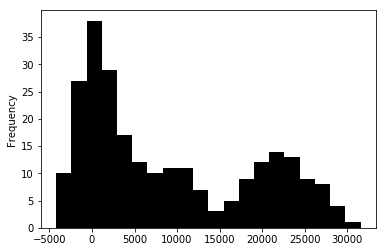

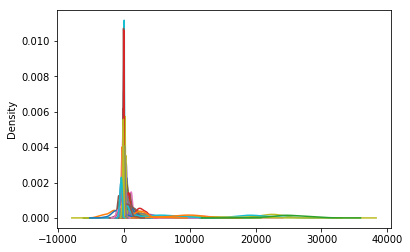

In [7]:
sample = sample.drop("cancer", axis=1)
sample.plot(kind="hist", legend=None, bins=20, color='k')
sample.plot(kind="kde", legend=None);

**Distribution of the random sample after standardizing**

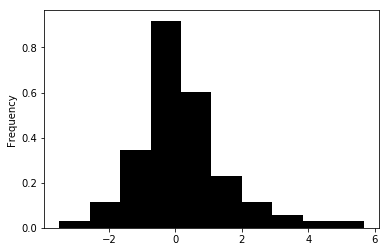

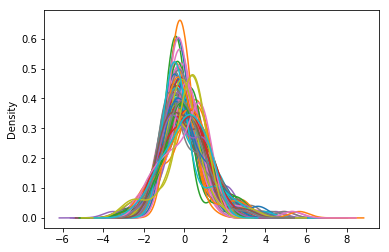

In [11]:
sample_scaled = pd.DataFrame(preprocessing.scale(sample))
sample_scaled.plot(kind="hist", density=True, legend=None, bins=10, color='k')
sample_scaled.plot(kind="kde", legend=None);

In [13]:
scaler = StandardScaler().fit(train.iloc[:,2:])
scaled_train = scaler.transform(train.iloc[:,2:])
scaled_test = scaler.transform(test.iloc[:,2:])

x_train = train.iloc[:,2:]
y_train = train.iloc[:,1]
x_test = test.iloc[:,2:]
y_test = test.iloc[:,1]

**Helper functions**

In [17]:
# CHERCHEZ FOR PARAMETERS
def cherchez(estimator, param_grid, search):
    """
    This is a helper function for tuning hyperparameters using teh two search methods.
    Methods must be GridSearchCV or RandomizedSearchCV.
    Inputs:
        estimator: Logistic regression, SVM, KNN, etc
        param_grid: Range of parameters to search
        search: Grid search or Randomized search
    Output:
        Returns the estimator instance, clf
    
    """   
    try:
        if search == "grid":
            clf = GridSearchCV(
                estimator=estimator, 
                param_grid=param_grid, 
                scoring=None,
                n_jobs=-1, 
                cv=10, 
                verbose=0,
                return_train_score=True
            )
        elif search == "random":           
            clf = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_grid,
                n_iter=10,
                n_jobs=-1,
                cv=10,
                verbose=0,
                random_state=1,
                return_train_score=True
            )
    except:
        print('Search argument has to be "grid" or "random"')
        sys.exit(0)
        
    # Fit the model
    clf.fit(X=scaled_train, y=y_train)
    
    return clf   

In [18]:
# Function for plotting the confusion matrices
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plots the confusion matrix. Modified verison from 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    Inputs: 
        cm: confusion matrix
        title: Title of plot
    """
    classes=["AML", "ALL"]    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.bone)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black")  

**Prediction Models**

**SVM**

**Grid search results**
('Best training accuracy:\t', 0.7105263157894737)
('Test accuracy:\t', 0.5882352941176471)
**Random search results**
('Best training accuracy:\t', 0.7105263157894737)
('Test accuracy:\t', 0.5882352941176471)


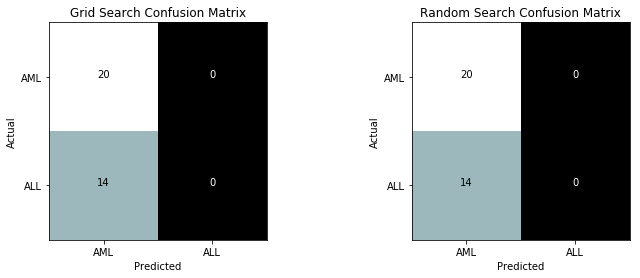

In [21]:
svm_param = {
    "C": [.01, .1, 1, 5, 10, 100],
    "gamma": [0, .01, .1, 1, 5, 10, 100],
    "kernel": ["rbf"],
    "random_state": [1]
}

svm_dist = {
    "C": scipy.stats.expon(scale=.01),
    "gamma": scipy.stats.expon(scale=.01),
    "kernel": ["rbf"],
    "random_state": [1]
}

svm_grid = cherchez(SVC(), svm_param, "grid")
acc = accuracy_score(y_true=y_test, y_pred=svm_grid.predict(scaled_test))
cfmatrix_grid = confusion_matrix(y_true=y_test, y_pred=svm_grid.predict(scaled_test))
print("**Grid search results**")
print("Best training accuracy:\t", svm_grid.best_score_)
print("Test accuracy:\t", acc)

svm_random = cherchez(SVC(), svm_dist, "random")
acc = accuracy_score(y_true=y_test, y_pred=svm_random.predict(scaled_test))
cfmatrix_rand = confusion_matrix(y_true=y_test, y_pred=svm_random.predict(scaled_test))
print("**Random search results**")
print("Best training accuracy:\t", svm_random.best_score_)
print("Test accuracy:\t", acc)

plt.subplots(1,2)
plt.subplots_adjust(left=-0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_confusion_matrix(cfmatrix_rand, title="Random Search Confusion Matrix")
plt.subplot(121)
plot_confusion_matrix(cfmatrix_grid, title="Grid Search Confusion Matrix")

**KNN**

**Grid search results**
('Best training accuracy:\t', 0.8947368421052632)
('Test accuracy:\t', 0.5588235294117647)
**Random search results**
('Best training accuracy:\t', 0.868421052631579)
('Test accuracy:\t', 0.5588235294117647)


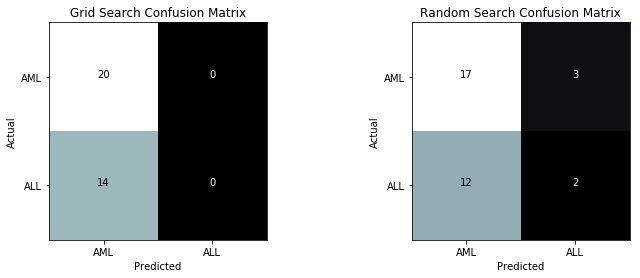

In [22]:
# KNN
knn_param = {
    "n_neighbors": [i for i in range(1,30,5)],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1, 10, 30],
    "p": [1,2]
}

knn_dist = {
    "n_neighbors": scipy.stats.randint(1,33),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": scipy.stats.randint(1,1000),
    "p": [1,2]
}

knn_grid = cherchez(KNeighborsClassifier(), knn_param, "grid")
acc = accuracy_score(y_true=y_test, y_pred=knn_grid.predict(scaled_test))
cfmatrix_grid = confusion_matrix(y_true=y_test, y_pred=svm_grid.predict(scaled_test))
print("**Grid search results**")
print("Best training accuracy:\t", knn_grid.best_score_)
print("Test accuracy:\t", acc)

knn_random = cherchez(KNeighborsClassifier(), knn_dist, "random")
acc = accuracy_score(y_true=y_test, y_pred=knn_random.predict(scaled_test))
cfmatrix_rand = confusion_matrix(y_true=y_test, y_pred=knn_random.predict(scaled_test))
print("**Random search results**")
print("Best training accuracy:\t", knn_random.best_score_)
print("Test accuracy:\t", acc)

plt.subplots(1,2)
plt.subplots_adjust(left=-0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_confusion_matrix(cfmatrix_rand, title="Random Search Confusion Matrix")
plt.subplot(121)
plot_confusion_matrix(cfmatrix_grid, title="Grid Search Confusion Matrix")

**Decision tree classifier**

**Grid search results**
('Best training accuracy:\t', 0.9736842105263158)
('Test accuracy:\t', 0.6176470588235294)


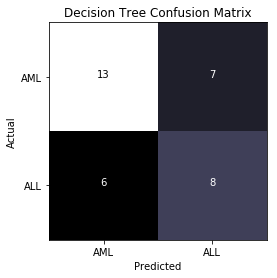

In [24]:
dtc_param = {
    "max_depth": [None],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "min_weight_fraction_leaf": [0.],
    "max_features": [None],
    "random_state": [4],
    "max_leaf_nodes": [None], # None = infinity or int
    "presort": [True, False]
}


dtc_grid = cherchez(DecisionTreeClassifier(), dtc_param, "grid")
acc = accuracy_score(y_true=y_test, y_pred=dtc_grid.predict(scaled_test))
cfmatrix_grid = confusion_matrix(y_true=y_test, y_pred=dtc_grid.predict(scaled_test))
print("**Grid search results**")
print("Best training accuracy:\t", dtc_grid.best_score_)
print("Test accuracy:\t", acc)

plot_confusion_matrix(cfmatrix_grid, title="Decision Tree Confusion Matrix")

**Coments**

SVM predicted that all 34 patients in the test data had AML and was right for 20 of them but wrong for the other 14 patients.

KNN with automated search for hyperparameters just overfits the training data and doesn't generalize to the test data but a randomized search produced a model which predicted that at least some of the patients had ALL.

Decision tree accurately predicted more ALL patients than any of the other models and had the lowest false positive rate. The model still has poor accuracy overall, doesn't generalize to the test data, and has a huge variance problem.

**Conclusions**

The GridSearch and RandomSearch use the model that fits the training data the best without taking into account how well it will generalizes to the test data.

It would be nice if GridSearch and RandomSearch could refit the best predictors that minimize the variance between the accuracy of train and validation sets. As it is, overfitting the training data has been a problem for each of these models.

**Sources:**
    
GeneChip: http://tools.thermofisher.com/content/sfs/manuals/data_analysis_fundamentals_manual.pdf

Golub et al: https://www.ncbi.nlm.nih.gov/pubmed/10521349

Bayesian optimization: https://arxiv.org/pdf/1012.2599v1.pdf
